In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dropout, Dense

In [4]:
df = pd.read_csv('data.txt',usecols=['<CLOSE>'], sep=";")
df

,<CLOSE>
0,59.2343
1,59.1927
2,59.2332
3,59.2332
4,59.4288
...,...
43398,74.0483
43399,74.1147
43400,74.1308
43401,74.0699


In [5]:
rates = np.array(df['<CLOSE>']).reshape(-1, 1)
rates

array([[59.2343],
       [59.1927],
       [59.2332],
       ...,
       [74.1308],
       [74.0699],
       [74.1201]])

In [6]:
scaler = MinMaxScaler()
normalized_rates = scaler.fit_transform(rates)

In [7]:
TIME_STEPS = 50

formatted_rates = []
for i in range(len(normalized_rates) - TIME_STEPS):
  formatted_rates.append(normalized_rates[i: i + TIME_STEPS + 1])

In [8]:
data = np.array(formatted_rates).astype('float32')
X = data[:, :-1]
y = data[:, -1]
X.shape, y.shape

((43353, 50, 1), (43353, 1))

In [9]:
split1 = 0.7
split2 = 0.9
boundary1 = int(data.shape[0]*split1)
boundary2 = int(data.shape[0]*split2)
train_x = X[: boundary1]
val_x = X[boundary1:boundary2]
test_x = X[boundary2:]
train_x.shape,val_x.shape, test_x.shape

((30347, 50, 1), (8670, 50, 1), (4336, 50, 1))

In [10]:
train_y = y[: boundary1]
val_y = y[boundary1:boundary2]
test_y = y[boundary2: ]
train_y.shape, val_y.shape, test_y.shape

((30347, 1), (8670, 1), (4336, 1))

In [11]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(256, input_shape=(TIME_STEPS, 1), unroll=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1))
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66305 (259.00 KB)
Trainable params: 66305 (259.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
rnn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
rnn_model.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(val_x, val_y),)

Epoch 1/10
475/475 [==============================] - 21s 37ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 2.1019e-04 - val_mse: 2.1019e-04
Epoch 2/10
475/475 [==============================] - 26s 55ms/step - loss: 3.8889e-04 - mse: 3.8889e-04 - val_loss: 2.7537e-04 - val_mse: 2.7537e-04
Epoch 3/10
475/475 [==============================] - 20s 42ms/step - loss: 3.1222e-04 - mse: 3.1222e-04 - val_loss: 9.1312e-05 - val_mse: 9.1312e-05
Epoch 4/10
475/475 [==============================] - 17s 36ms/step - loss: 2.7302e-04 - mse: 2.7302e-04 - val_loss: 1.1072e-04 - val_mse: 1.1072e-04
Epoch 5/10
475/475 [==============================] - 17s 36ms/step - loss: 2.4605e-04 - mse: 2.4605e-04 - val_loss: 3.4704e-05 - val_mse: 3.4704e-05
Epoch 6/10
475/475 [==============================] - 18s 37ms/step - loss: 2.2975e-04 - mse: 2.2975e-04 - val_loss: 2.5125e-04 - val_mse: 2.5125e-04
Epoch 7/10
475/475 [==============================] - 16s 35ms/step - loss: 2.1786e-04 - mse: 2.1786e-04 - v

In [13]:
test_loss, test_acc = rnn_model.evaluate(test_x, test_y, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

136/136 [==============================] - 1s 6ms/step - loss: 7.1967e-05 - mse: 7.1967e-05

Test Accuracy: 7.196706428658217e-05
Test Loss:     7.196706428658217e-05


In [14]:
rnn_predict = rnn_model.predict(test_x)
rnn_predict[:5]

136/136 [==============================] - 1s 5ms/step


array([[0.66235375],
       [0.6619746 ],
       [0.66181767],
       [0.66147673],
       [0.6622302 ]], dtype=float32)

In [15]:
rnn_predict = np.reshape(rnn_predict, (rnn_predict.size, ))
rnn_predict_y = scaler.inverse_transform([[i] for i in rnn_predict])
rnn_predict_y[:5]

array([[72.62907339],
       [72.61525756],
       [72.6095388 ],
       [72.5971152 ],
       [72.62457092]])

In [16]:
true_y = scaler.inverse_transform(test_y)
true_y[:5]

array([[72.863304],
       [72.851   ],
       [72.836   ],
       [72.9279  ],
       [72.835   ]], dtype=float32)

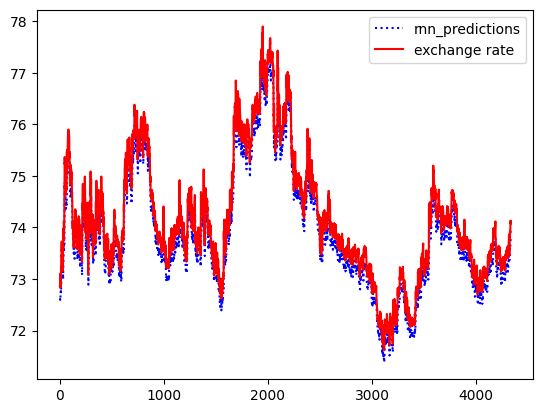

In [17]:
plt.plot(rnn_predict_y, 'b:')
plt.plot(true_y, 'r-')
plt.legend(['rnn_predictions','exchange rate'])
plt.show()